In [1]:
#Importing libraries
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import sdt.changepoint as c
import math

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import numpy as np

In [3]:
# create a dataframe from the csv file
df_new_cases = pd.read_csv('../data/WHO-COVID-19-global-data.csv')
df_vaccination = pd.read_csv('../data/owid-covid-data.csv')

In [4]:
# add moving average for new cases
df_vaccination['moving_average_new_vaccinations'] = df_vaccination.groupby('iso_code')['new_vaccinations'].transform(lambda x: x.rolling(window=7).mean())

# rimuovi tutte le righe che non hanno un valore o hanno un valore a "0.0" per moving_average_new_cases
df_vaccination = df_vaccination.dropna(subset=['moving_average_new_vaccinations'])
df_vaccination = df_vaccination[df_vaccination['moving_average_new_vaccinations'] != 0.0]

In [5]:
# add moving average for new cases
df_new_cases['moving_average_new_cases'] = df_new_cases.groupby('Country_code')['New_cases'].transform(lambda x: x.rolling(window=7).mean())

# rimuovi tutte le righe che non hanno un valore o hanno un valore a "0.0" per moving_average_new_cases
df_new_cases = df_new_cases.dropna(subset=['moving_average_new_cases'])
df_new_cases = df_new_cases[df_new_cases['moving_average_new_cases'] != 0.0]

In [6]:
# firter data from 2021-07-16 to 2021-08-15
start_date = date(2021, 7, 15) 
og_start_date = date(2021, 7, 22)
og_end_date = date(2021, 8, 9)
end_date = date(2021, 8, 28)

difference = og_start_date - start_date

# filter data from 2021-07-16 to 2021-08-15
df_new_cases = df_new_cases[(df_new_cases['Date_reported'] >= str(start_date)) & (df_new_cases['Date_reported'] <= str(end_date))]

# filter df_vaccination from 2021-07-16 to 2021-08-15
df_vaccination = df_vaccination[(df_vaccination['date'] >= str(start_date)) & (df_vaccination['date'] <= str(end_date))]

In [7]:
#filter by iso_cod that not contain "OWID" prefix
df_vaccination = df_vaccination[~df_vaccination['iso_code'].str.contains("OWID")]

# aggragate by iso_code and date and sum total_cases, total_deaths, population, total_vaccinations, new_cases, mind positive_rate, max positive_rate,KEEP LOCATION 
df_vaccination = df_vaccination.groupby(['iso_code', 'date']).agg({'people_vaccinated':'sum', 'new_vaccinations': 'sum', 'location': 'max', 'moving_average_new_vaccinations': 'sum'})

In [8]:
# save dataframe in csv file
df_new_cases.to_csv('./dataframe.csv')
df_vaccination.to_csv('./vaccinations.csv')

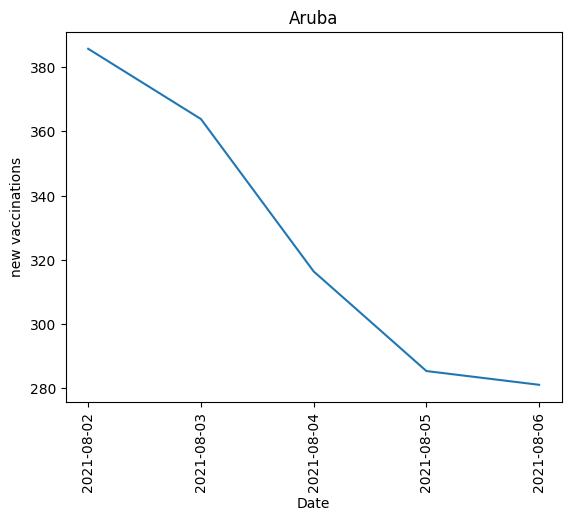

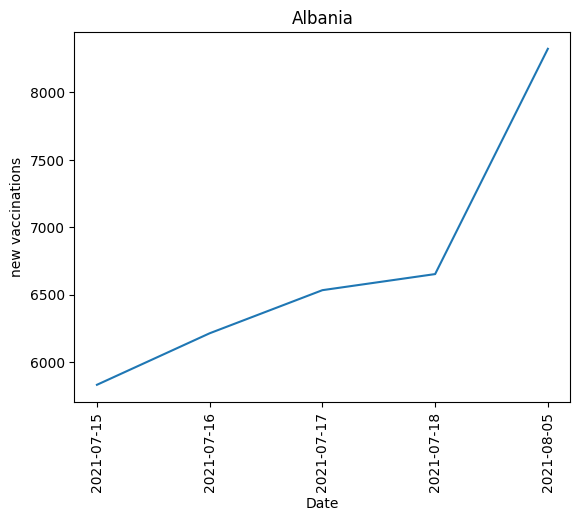

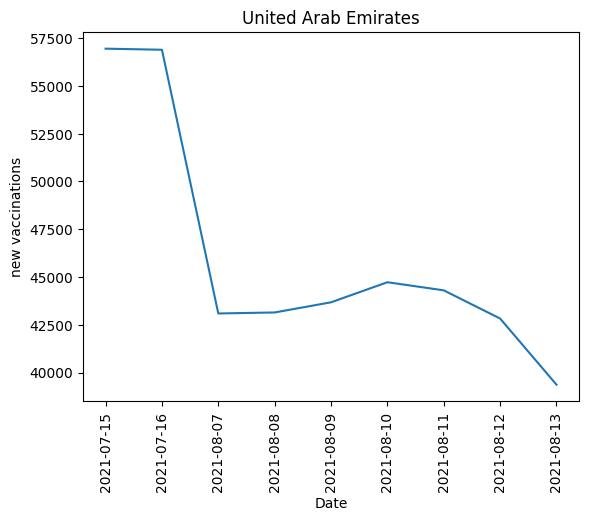

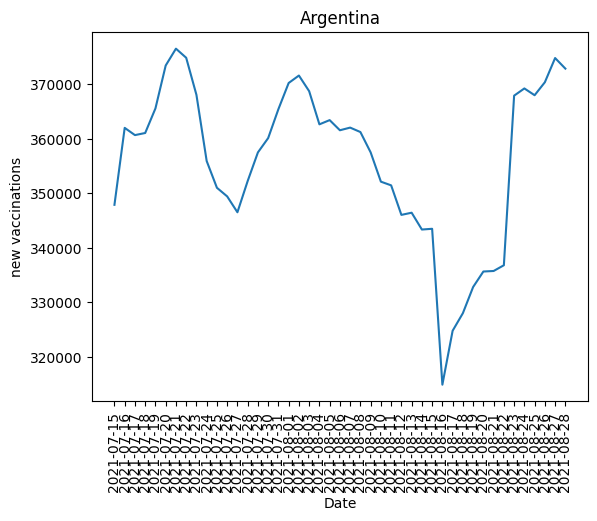

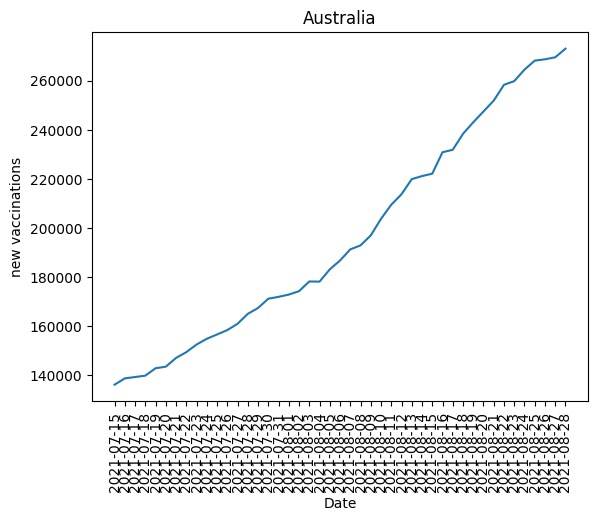

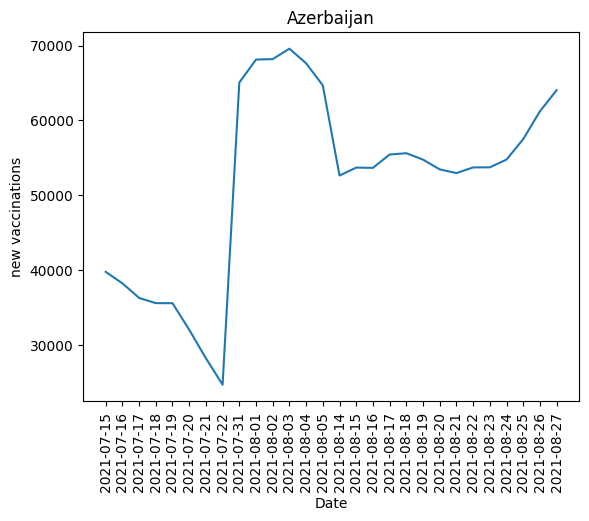

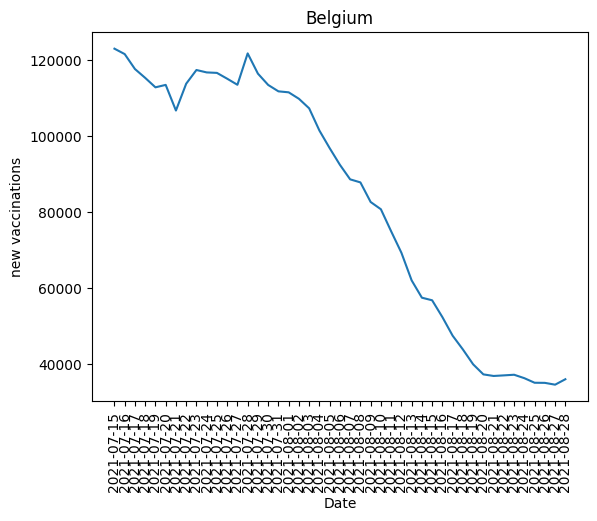

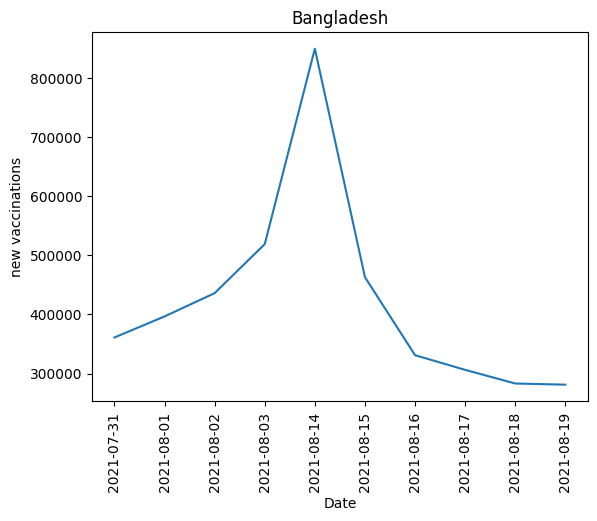

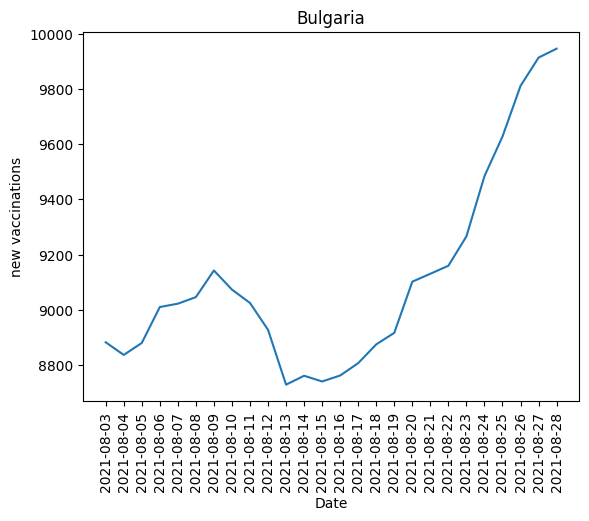

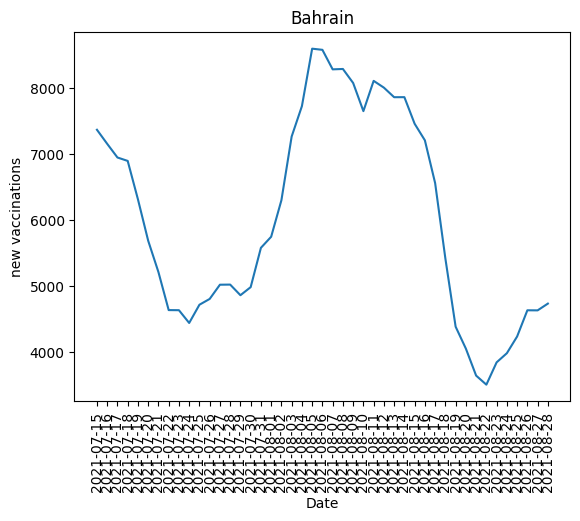

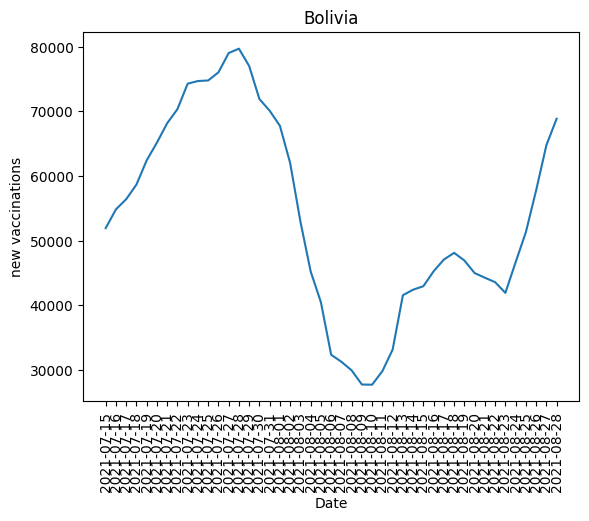

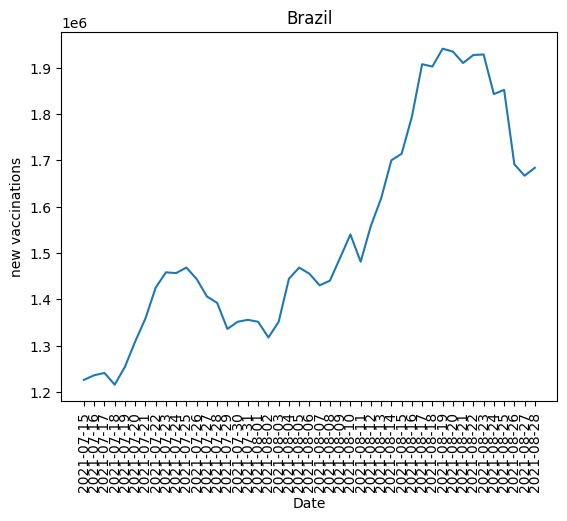

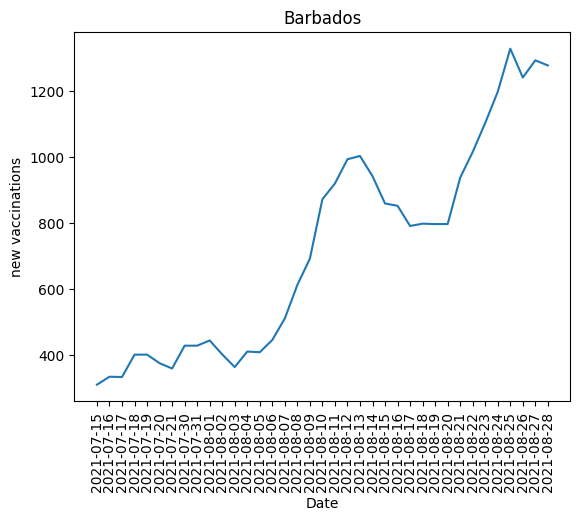

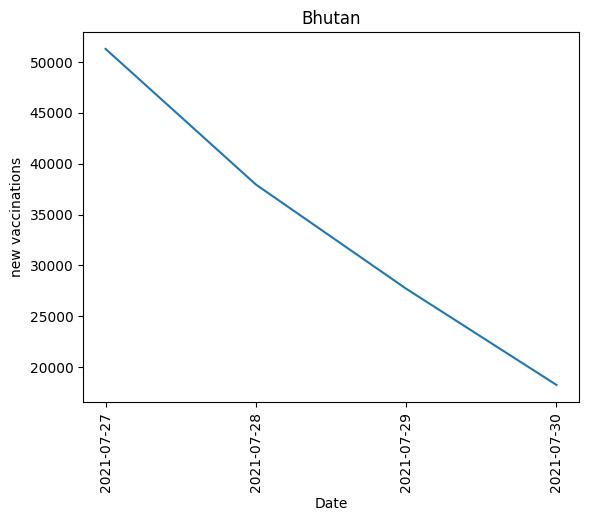

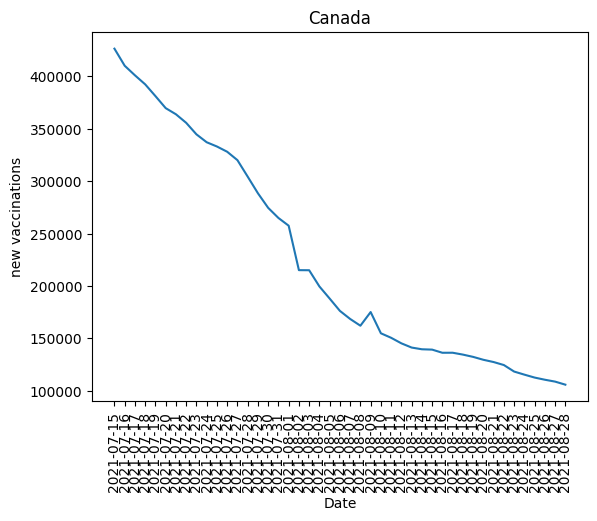

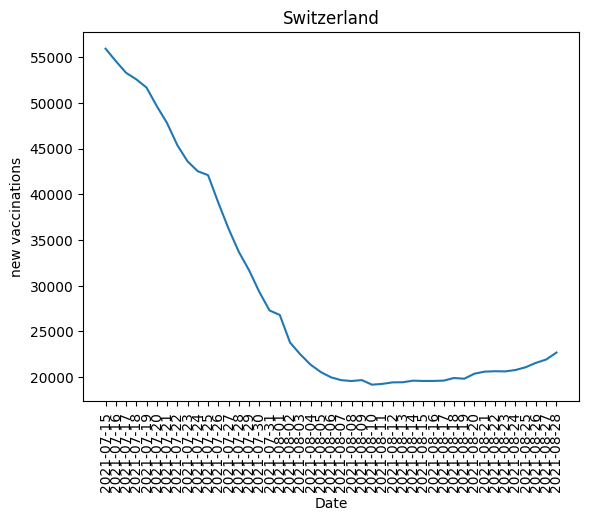

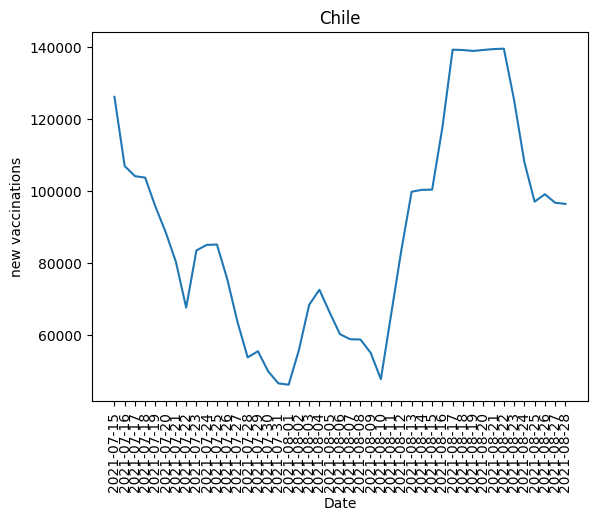

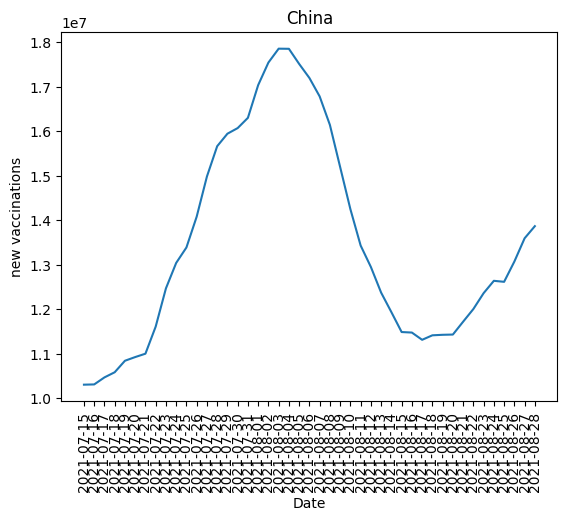

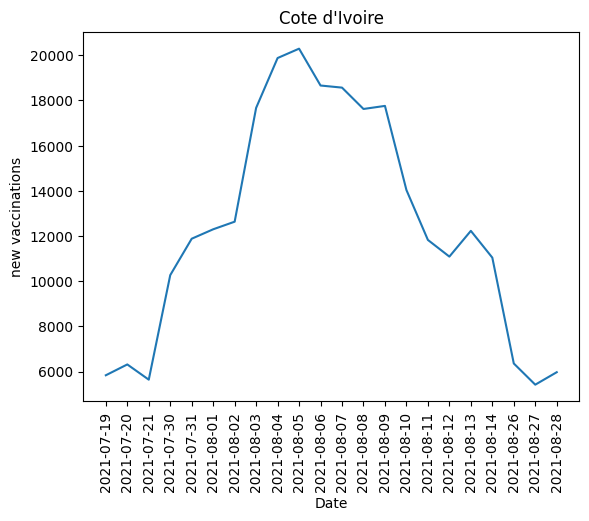

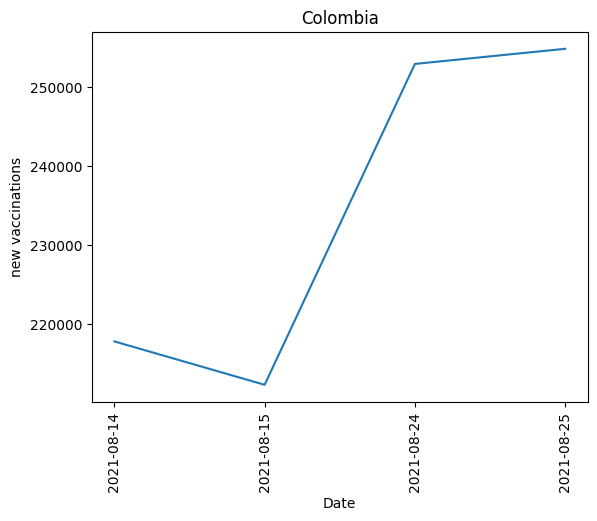

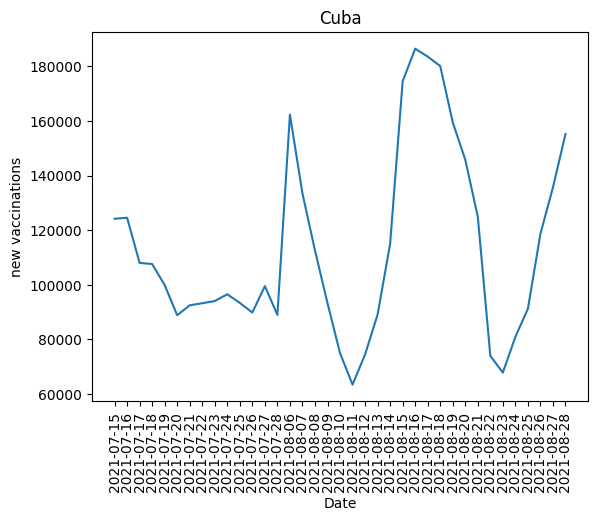

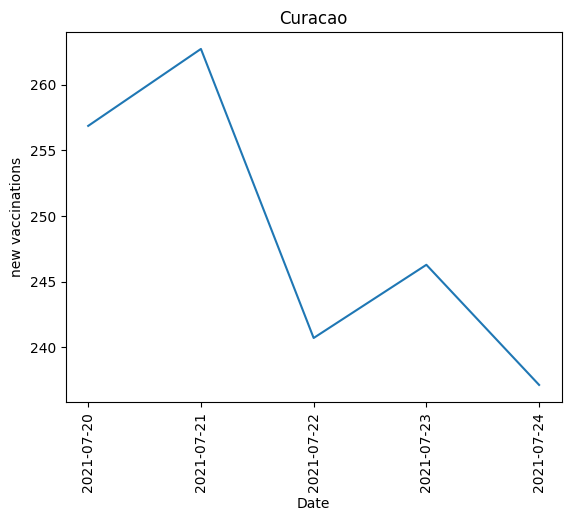

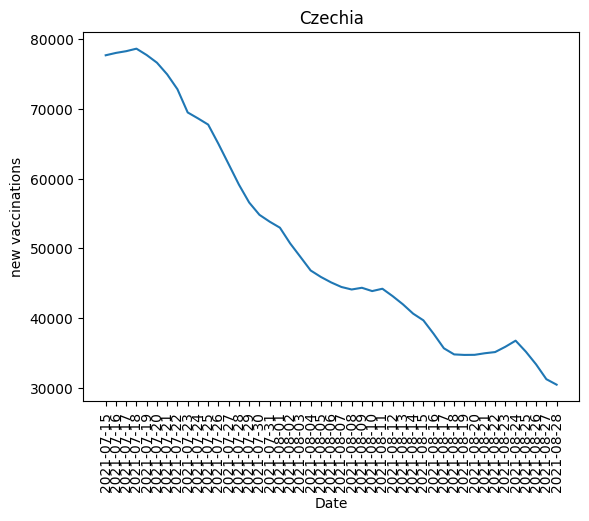

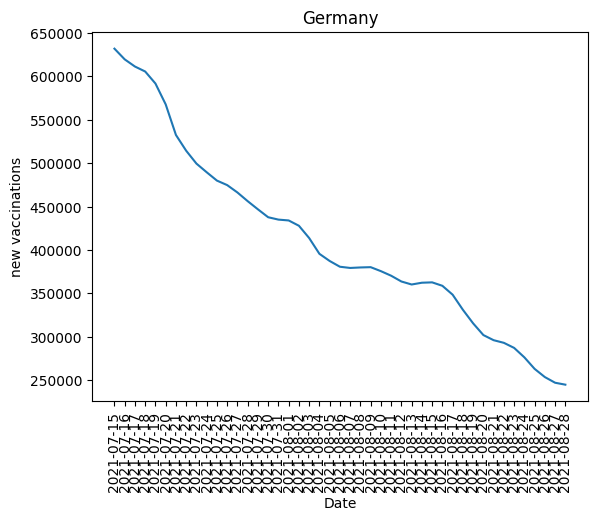

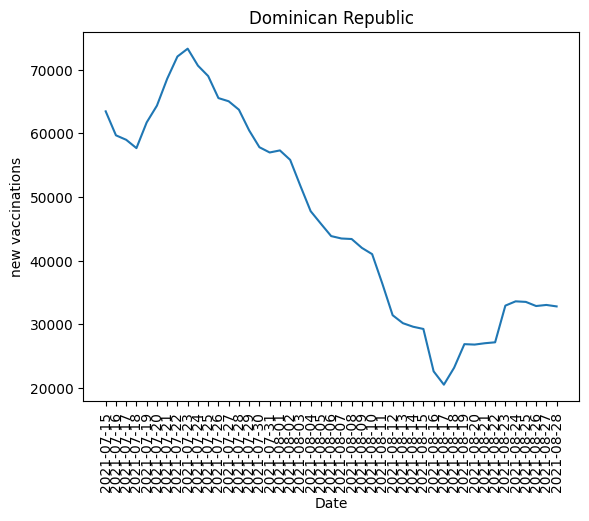

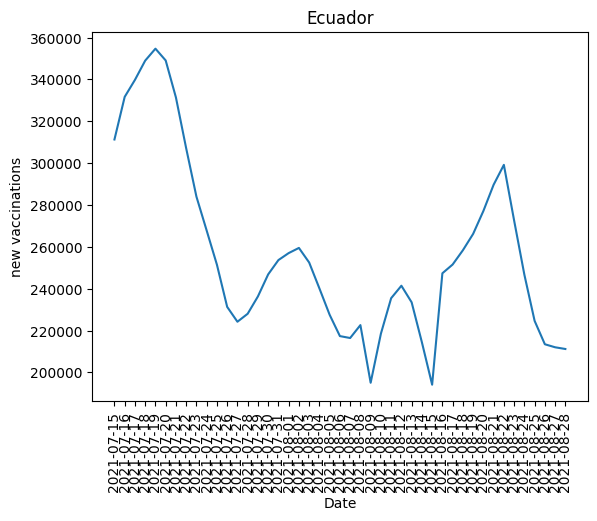

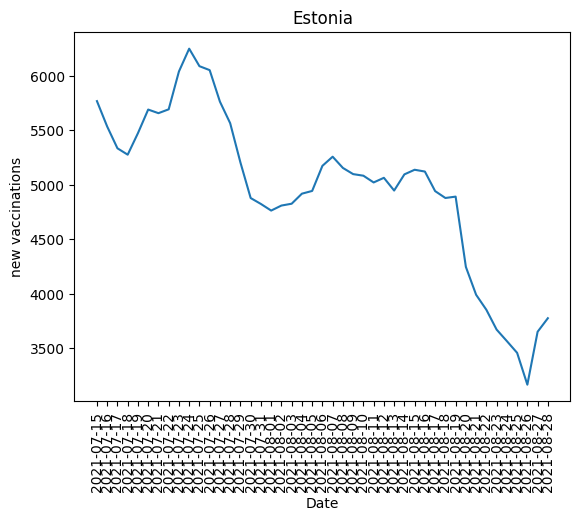

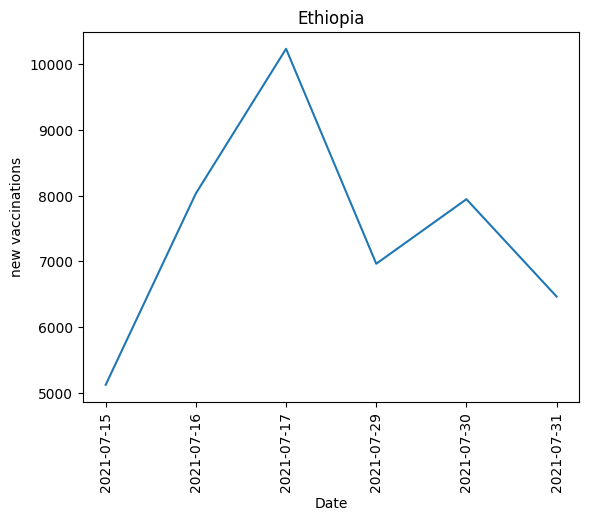

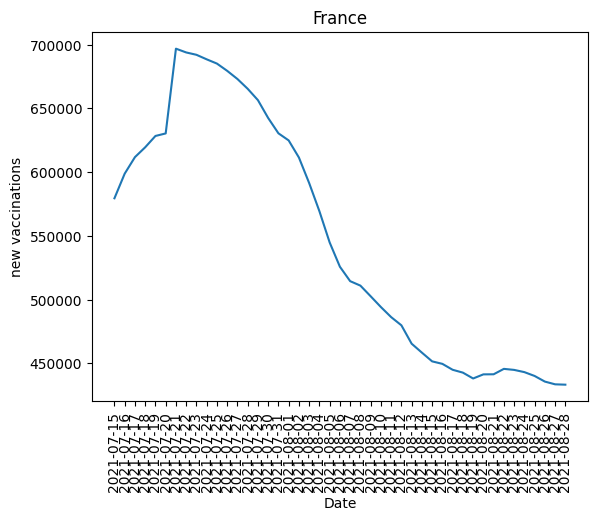

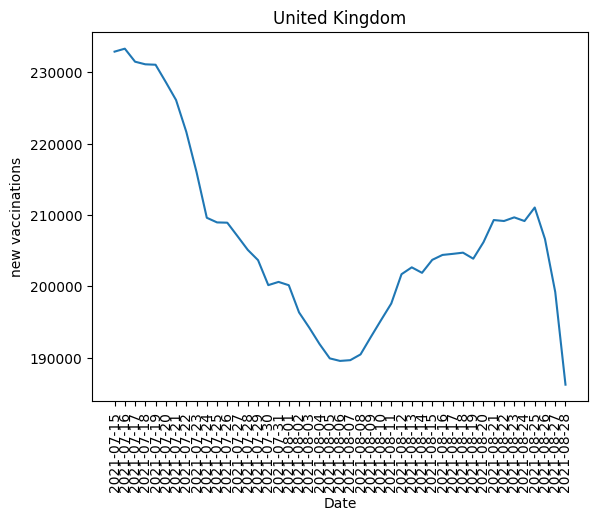

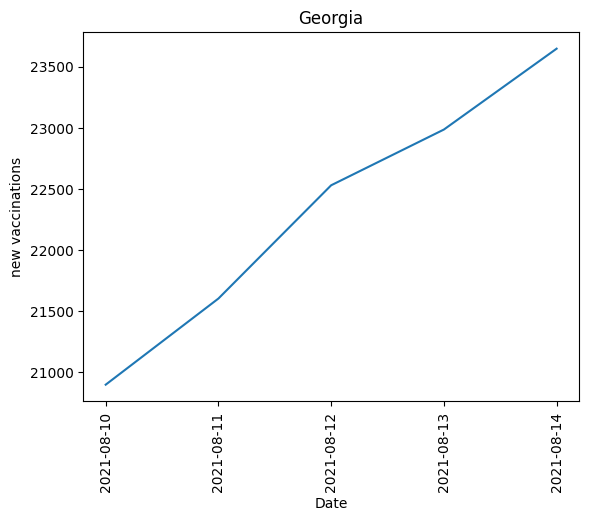

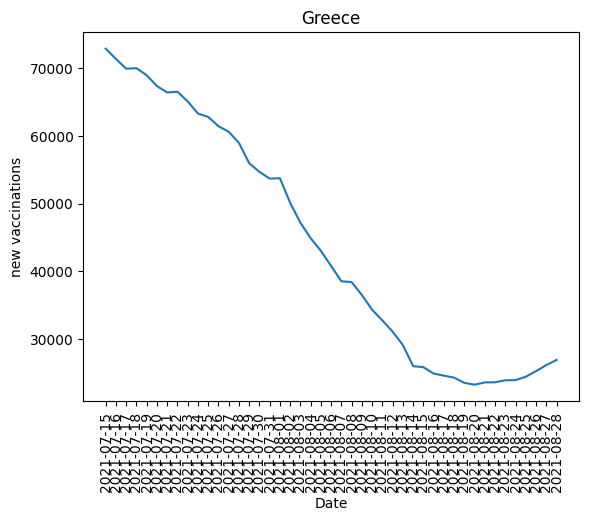

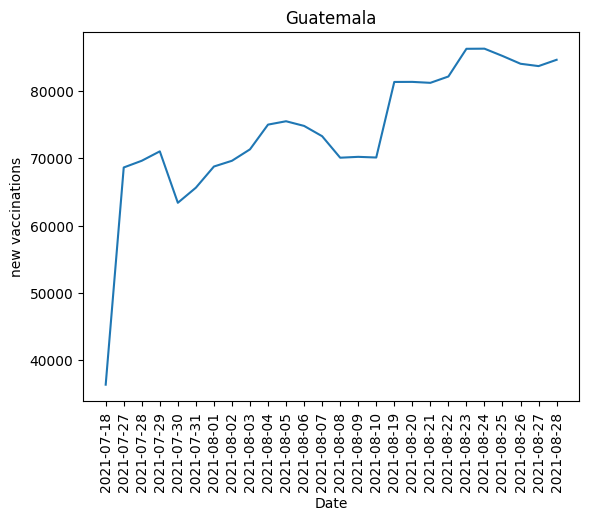

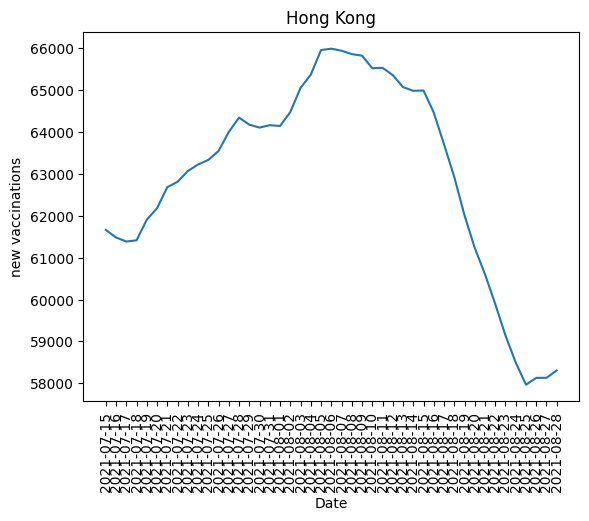

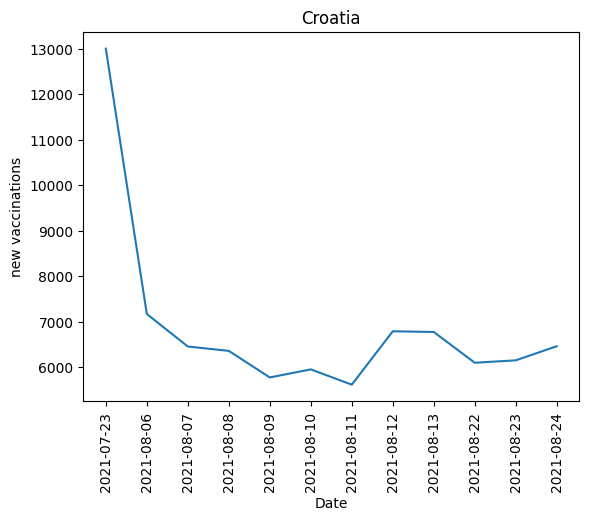

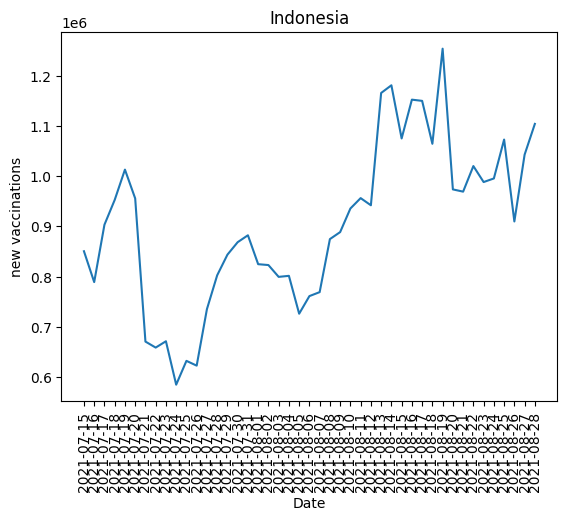

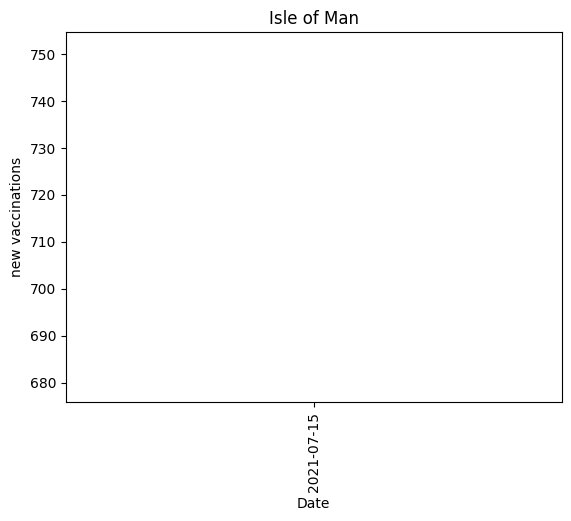

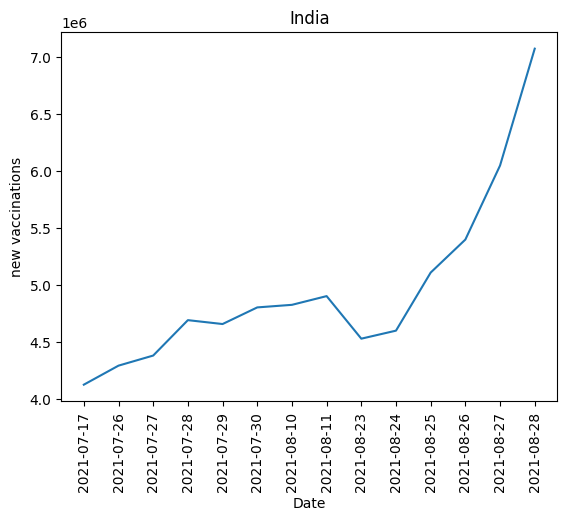

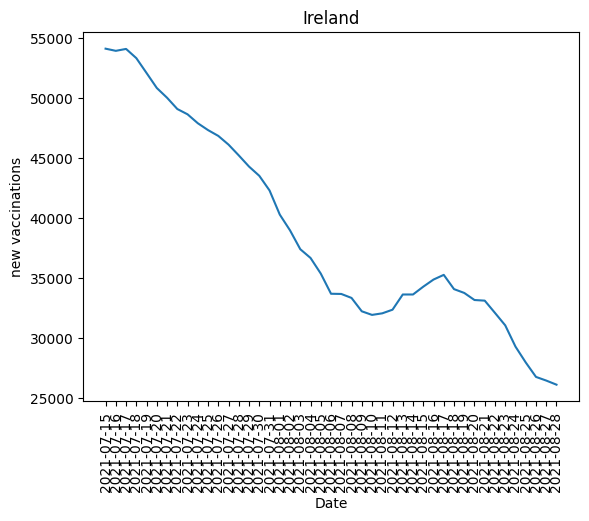

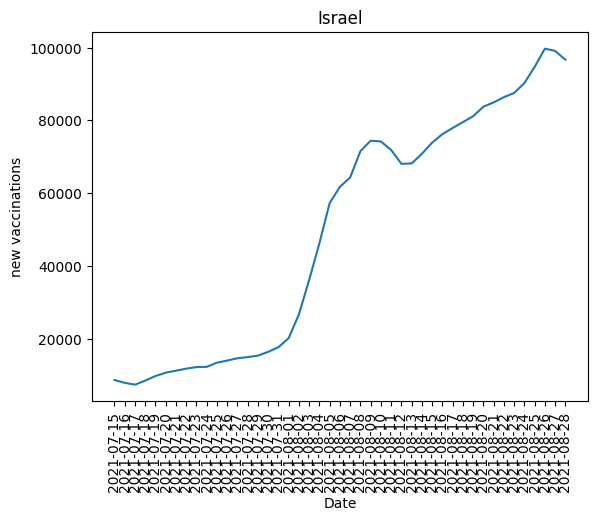

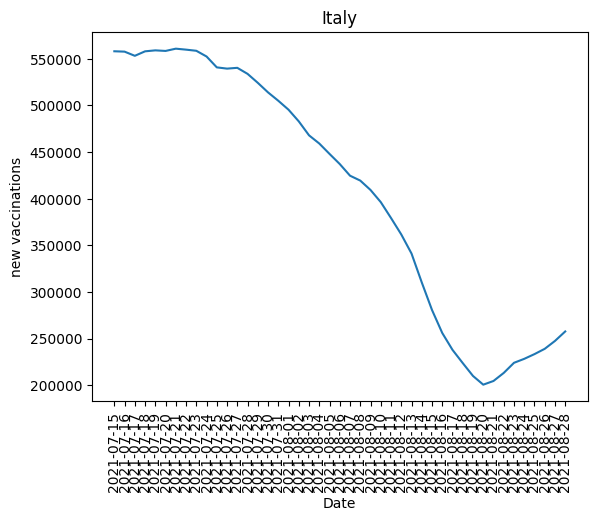

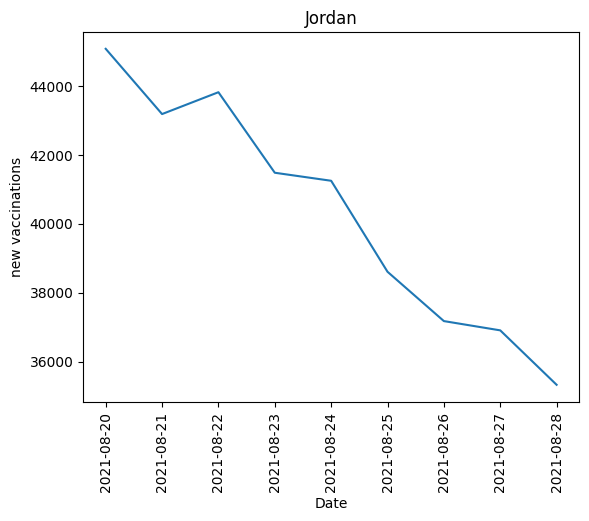

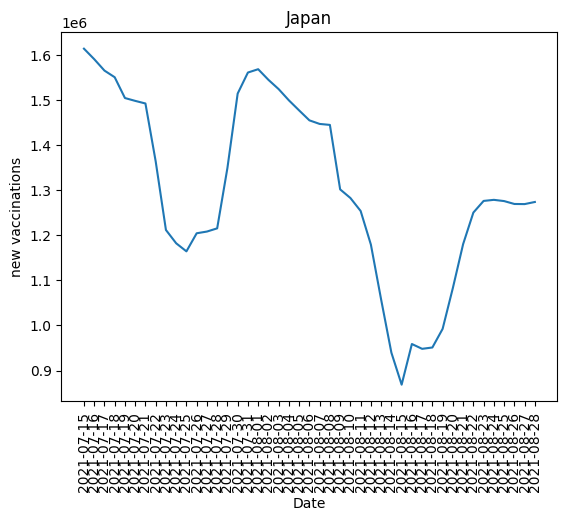

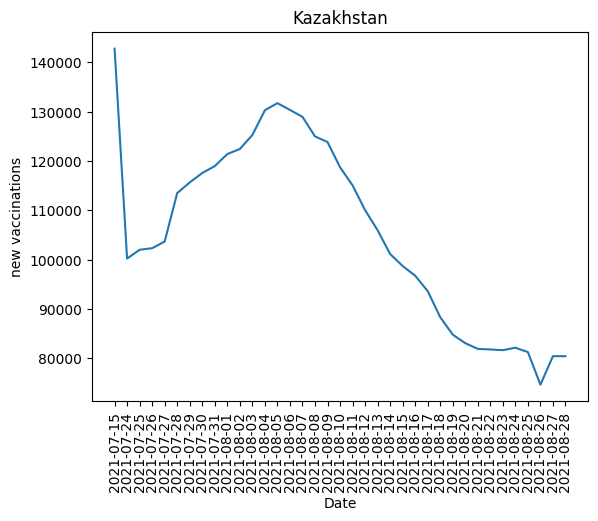

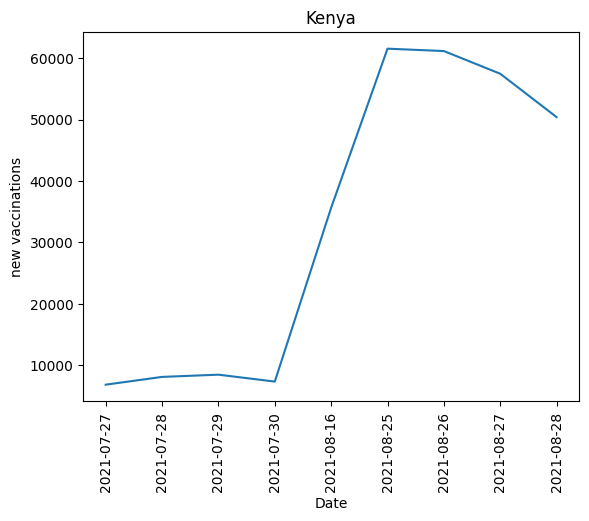

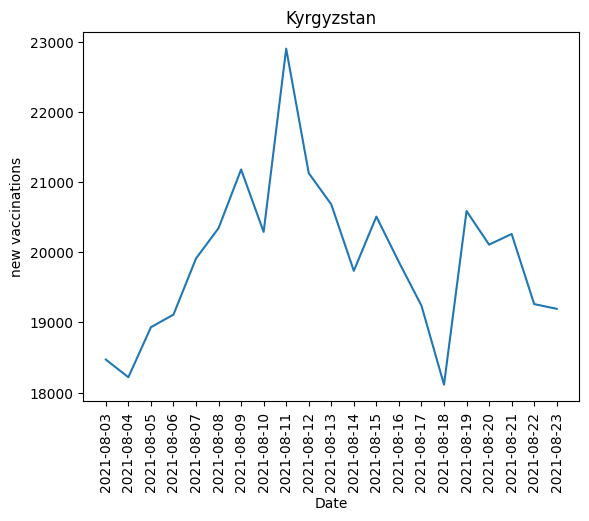

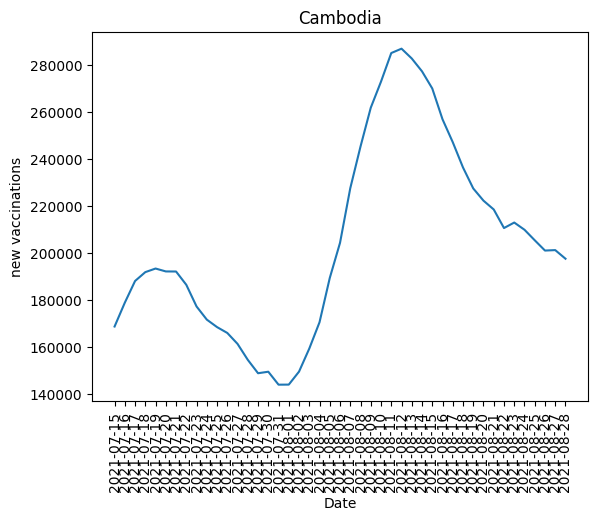

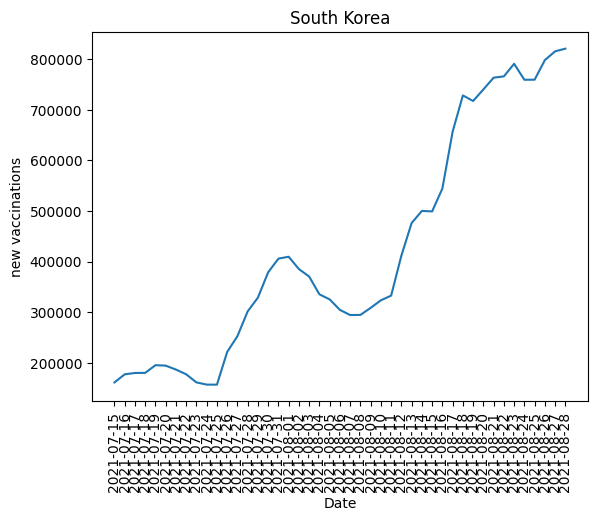

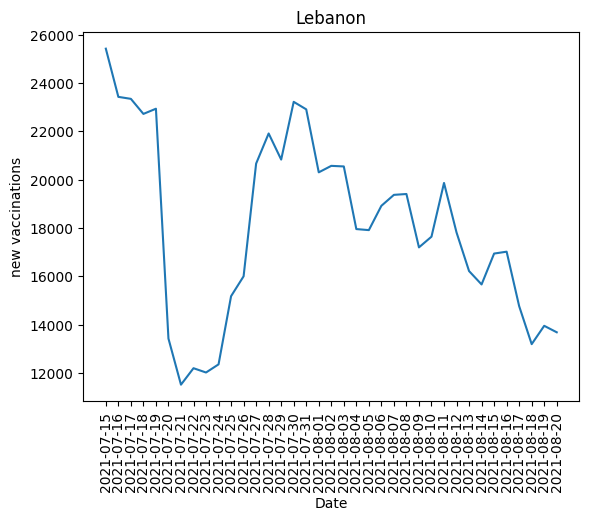

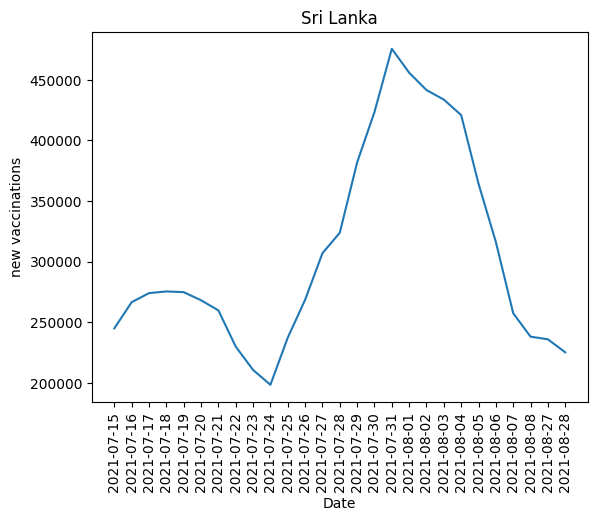

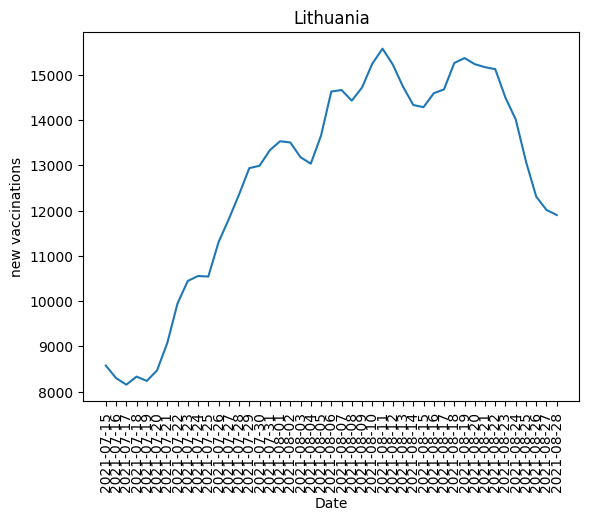

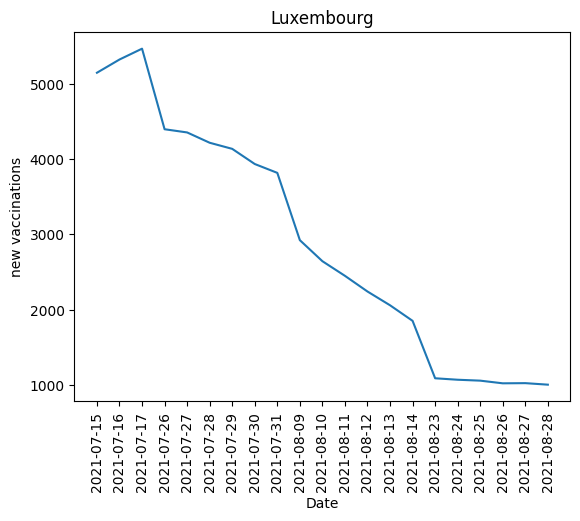

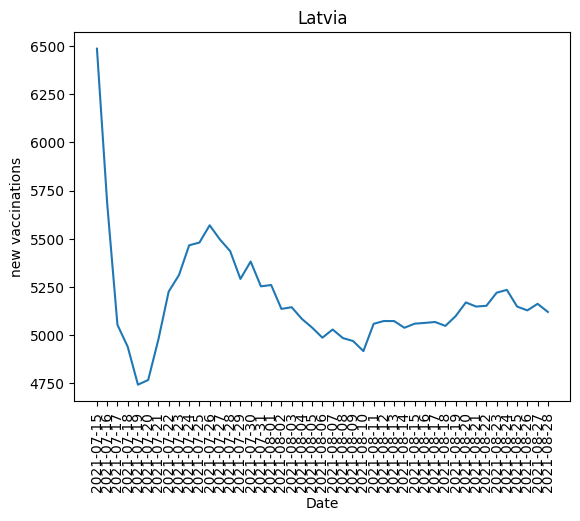

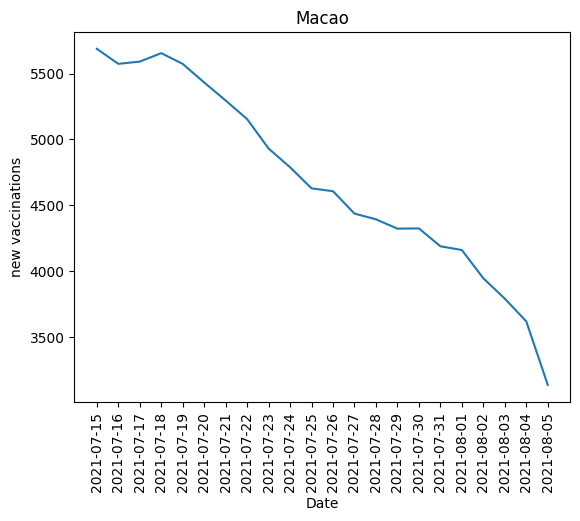

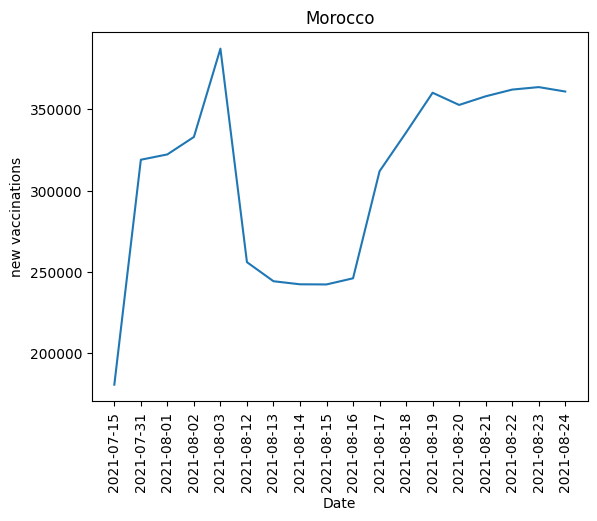

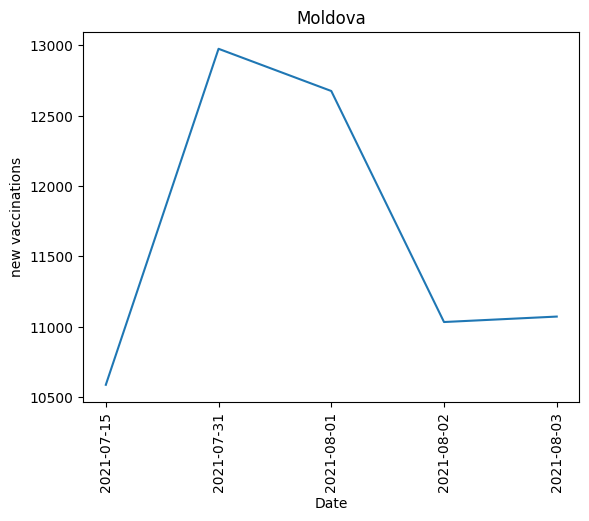

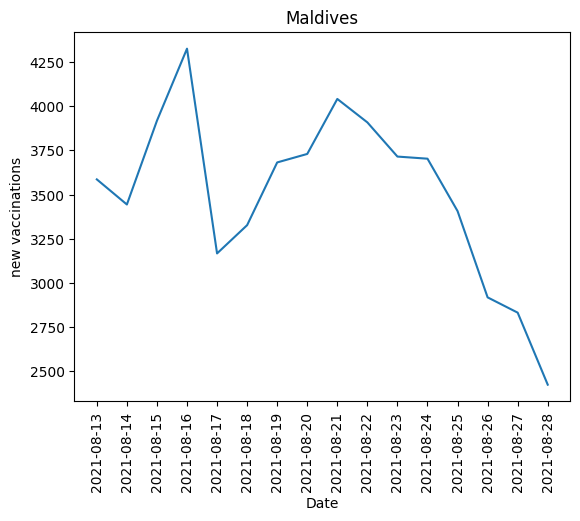

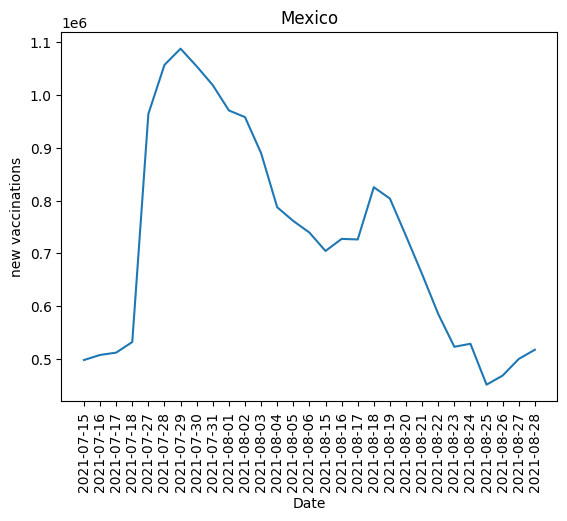

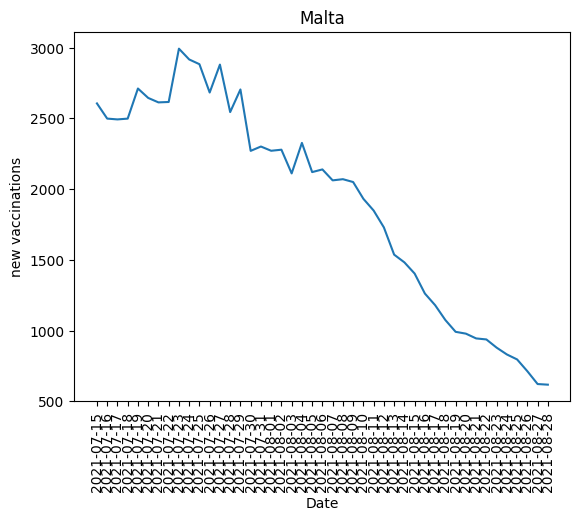

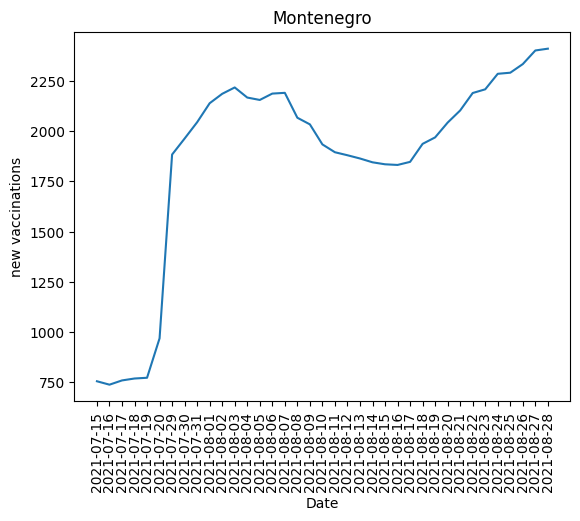

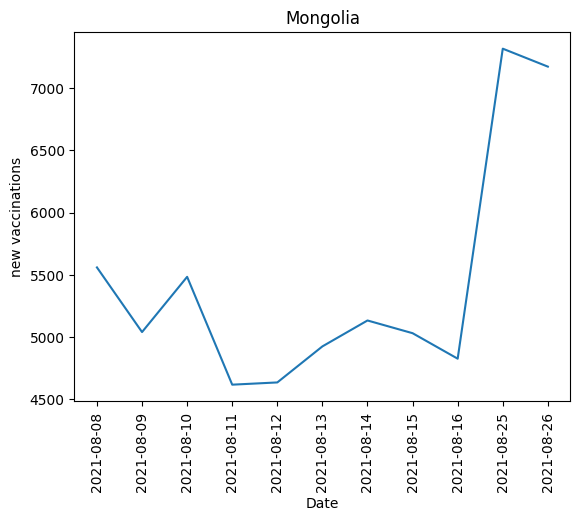

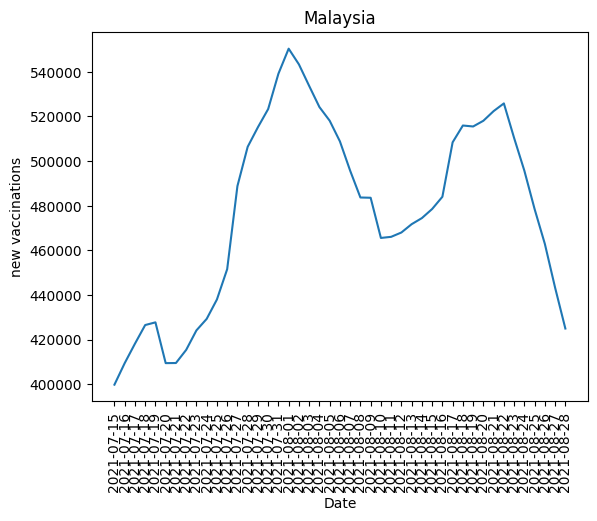

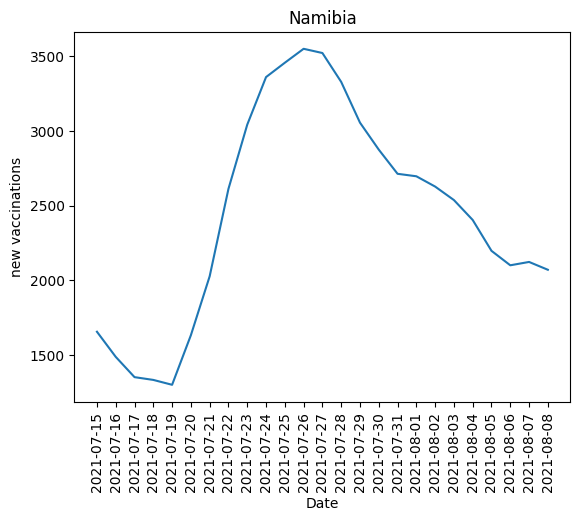

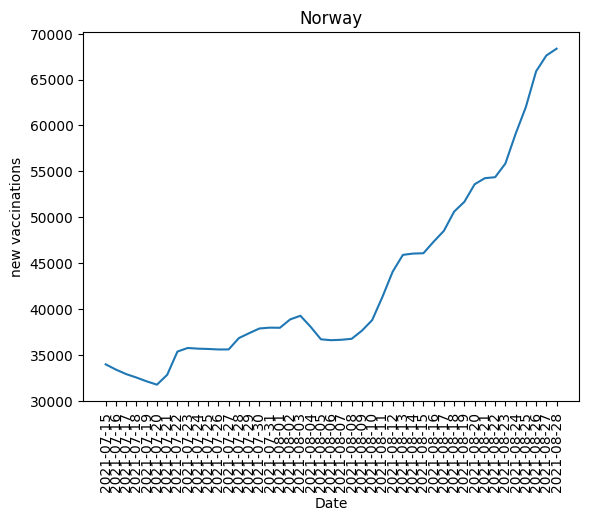

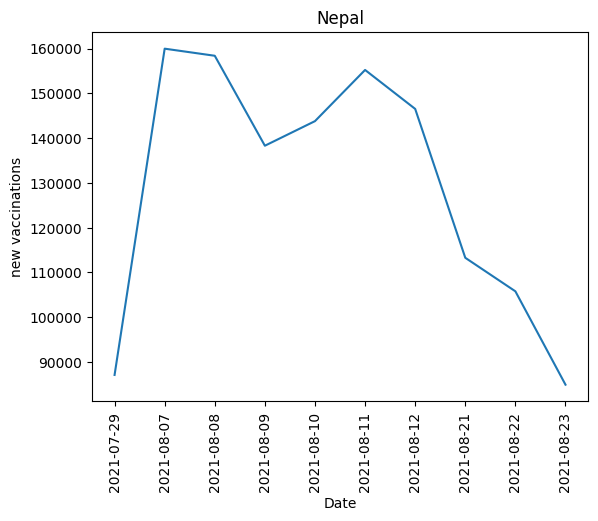

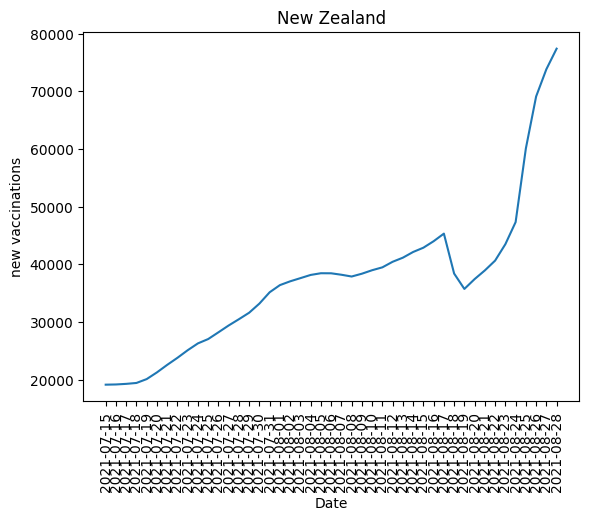

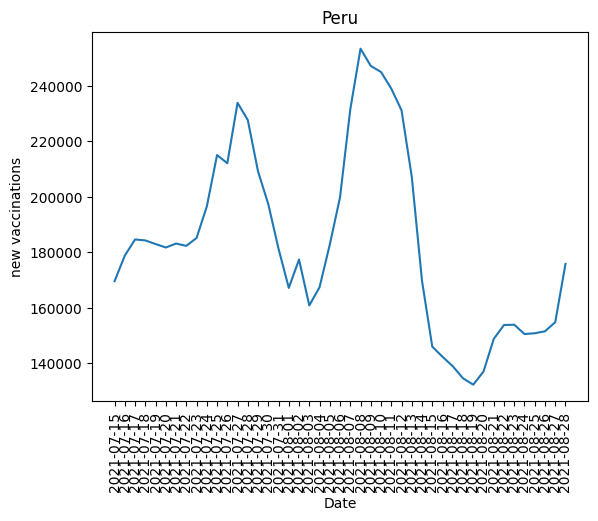

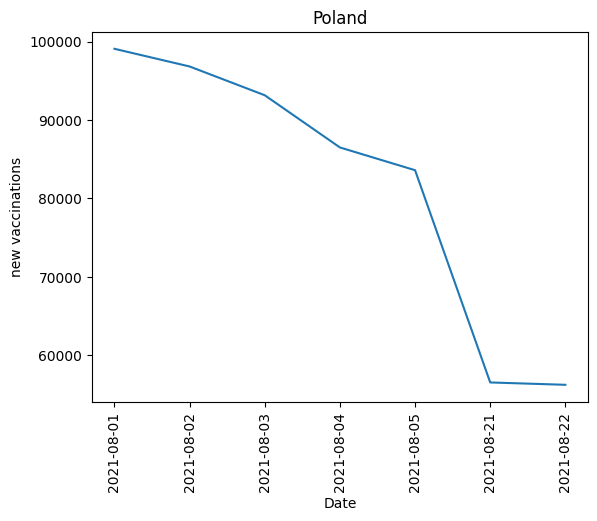

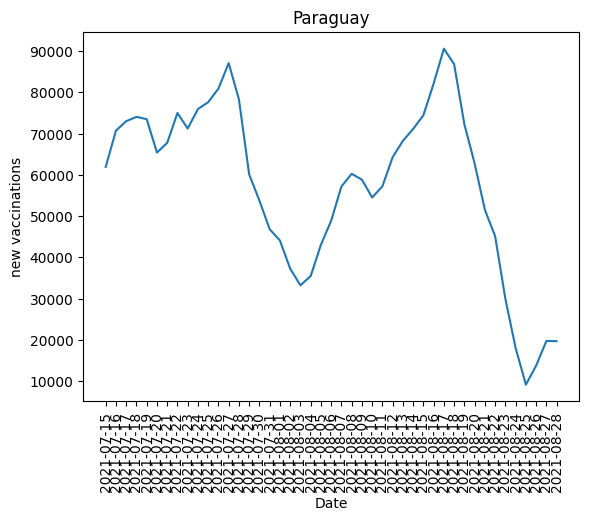

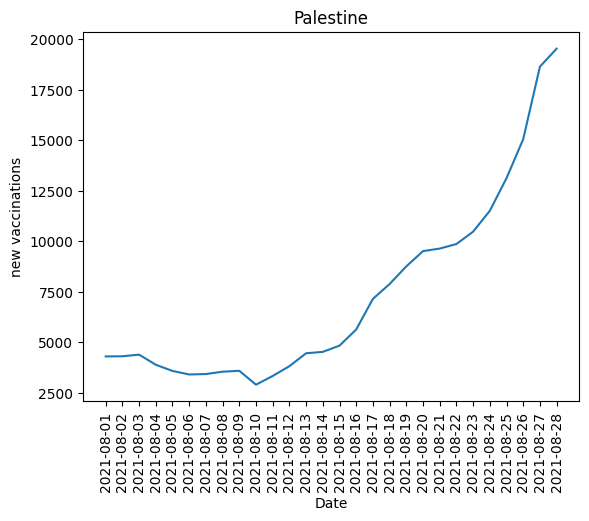

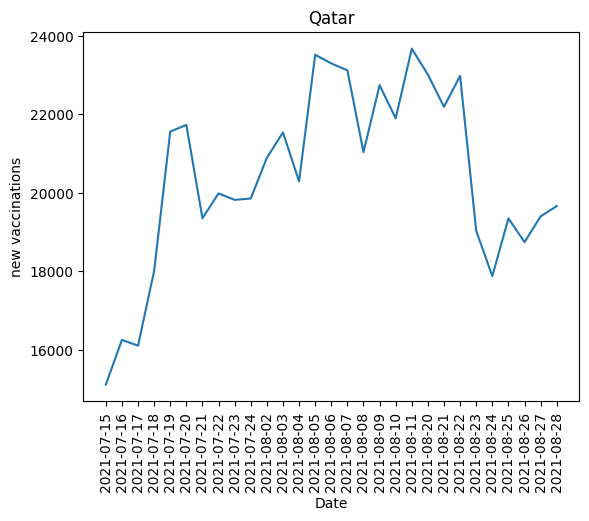

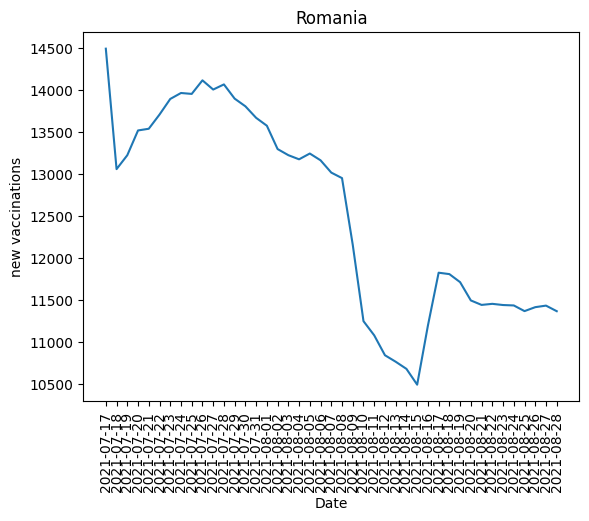

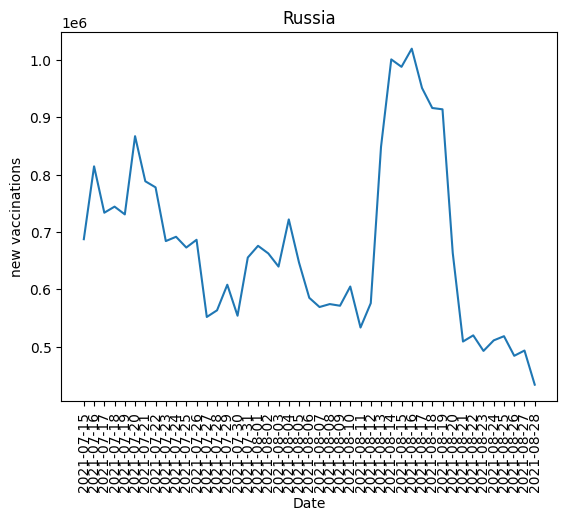

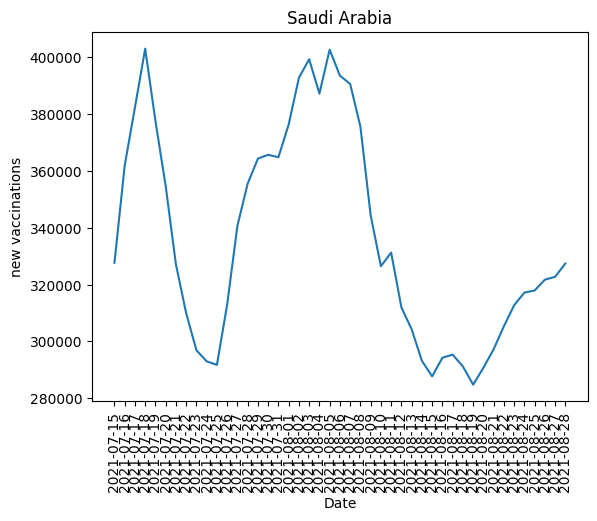

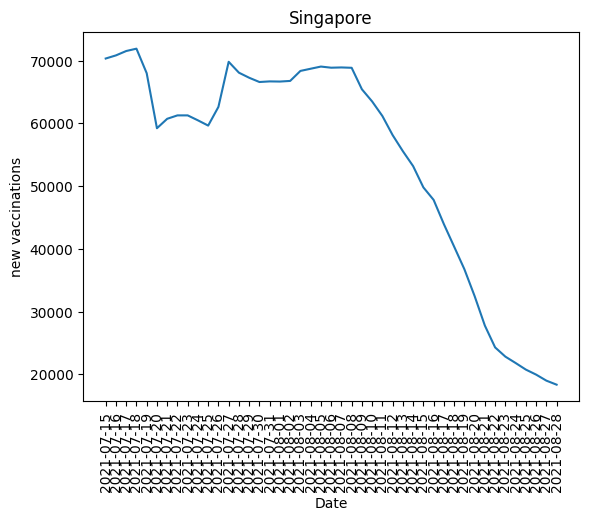

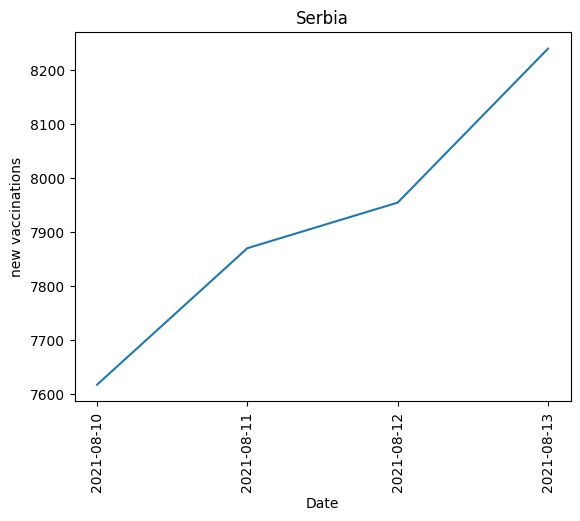

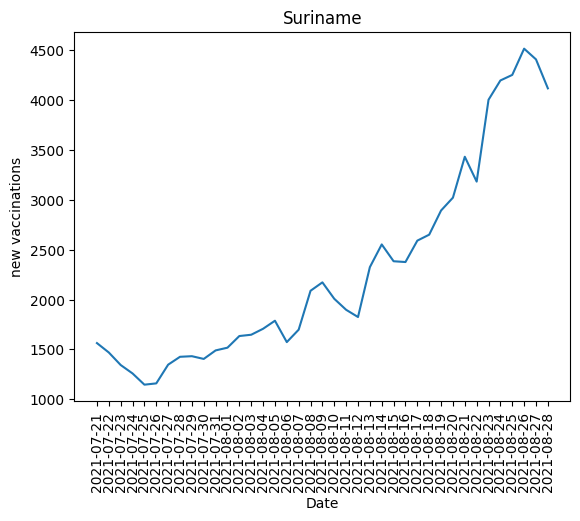

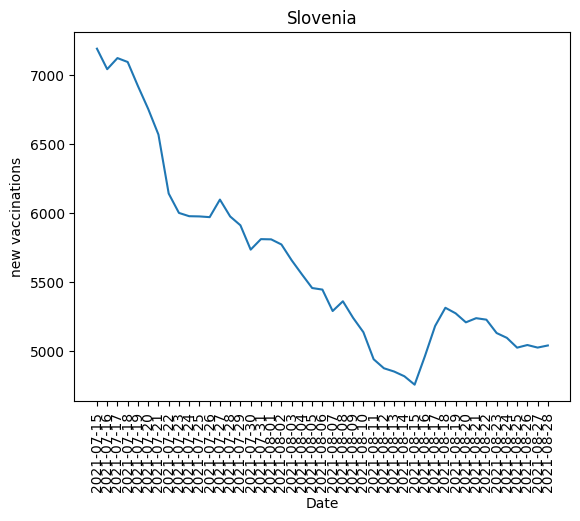

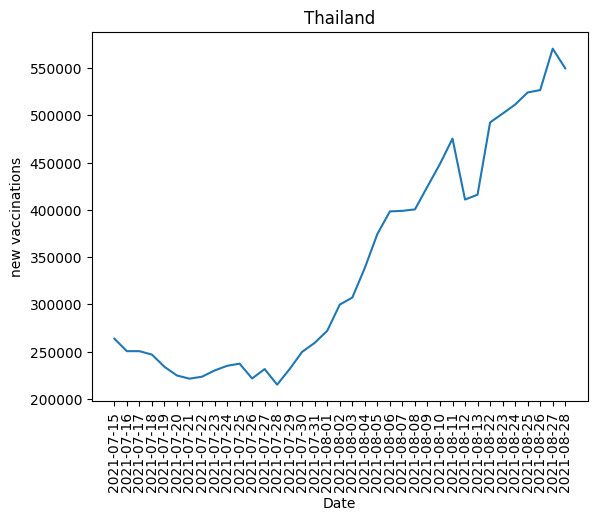

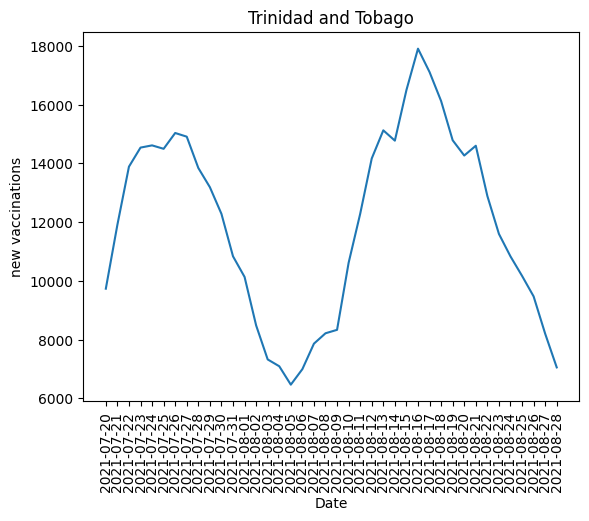

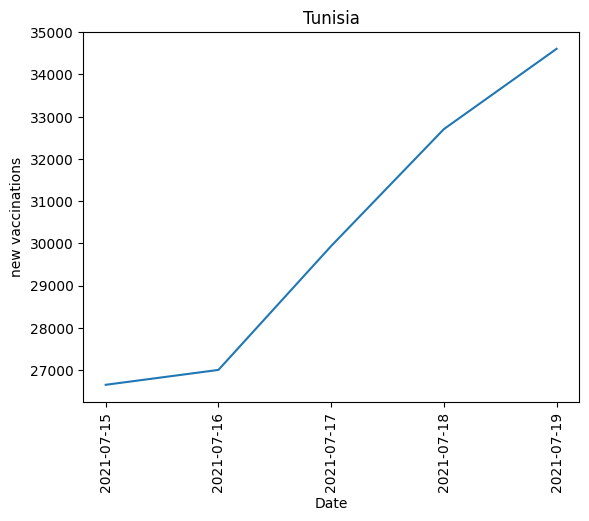

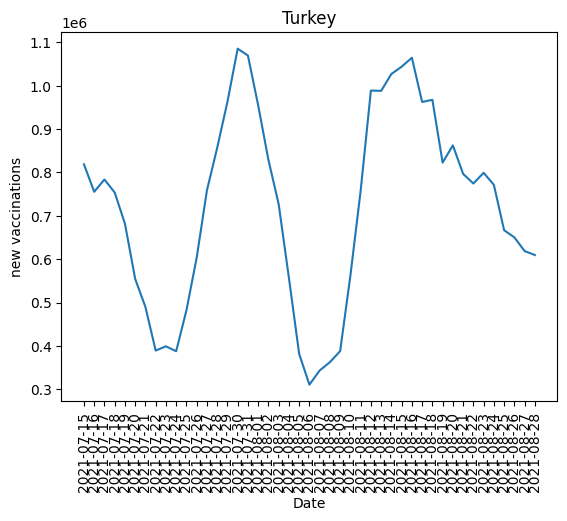

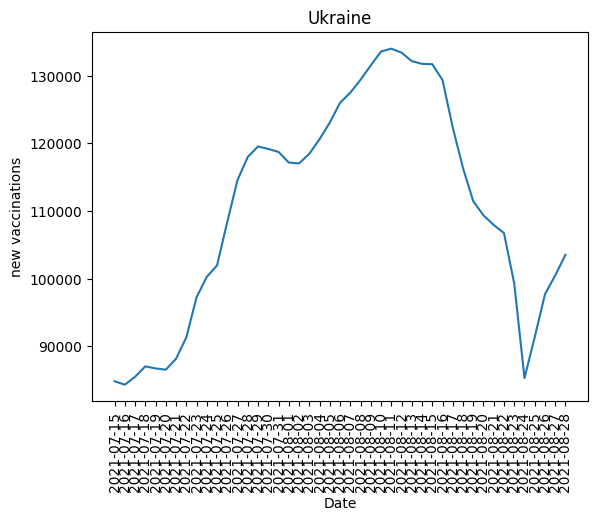

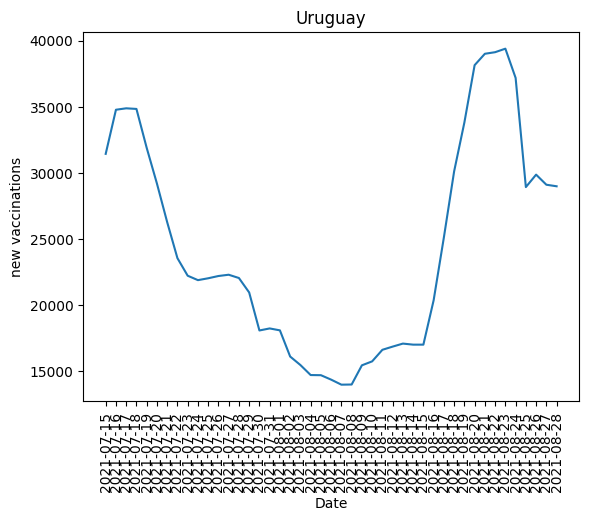

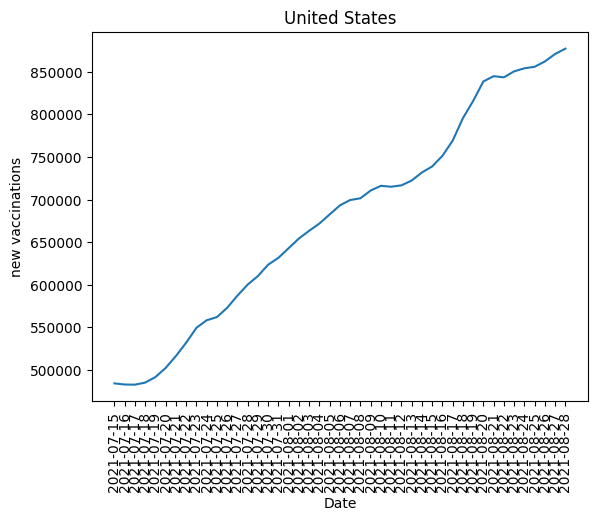

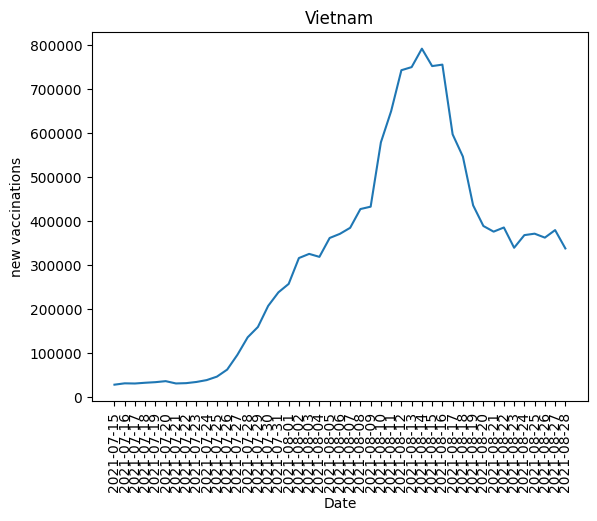

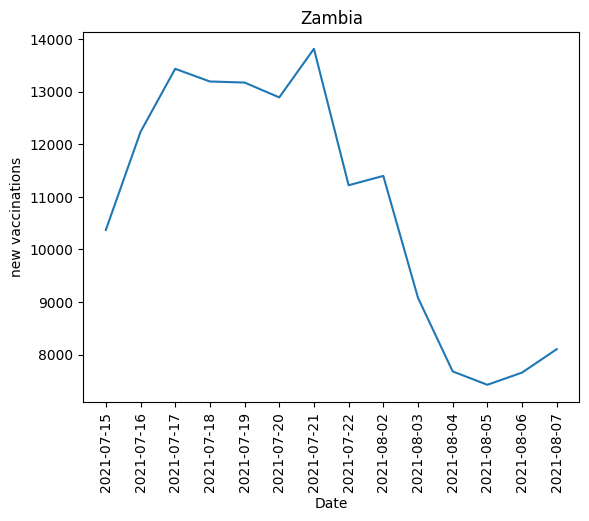

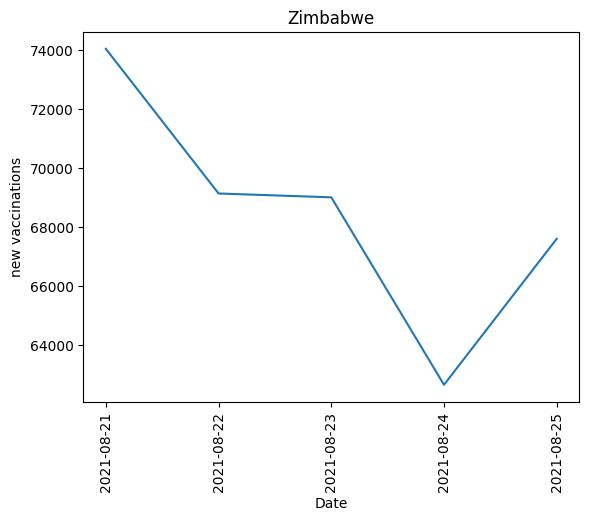

In [9]:
for iso_code in df_vaccination.index.get_level_values('iso_code').unique():
    plt.plot(df_vaccination.loc[iso_code]['moving_average_new_vaccinations'], label='vaccinations')
    plt.title(df_vaccination.loc[iso_code]['location'].unique()[0])
    plt.ylabel("new vaccinations")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    plt.show()

In [10]:
# aggragate by iso_code and date and sum total_cases, total_deaths, population, total_vaccinations, new_cases, mind positive_rate, max positive_rate,KEEP LOCATION 
df_new_cases = df_new_cases.groupby(['Country_code', 'Date_reported']).agg({'Country': 'sum', 'WHO_region': 'sum', 'New_cases': 'sum', 'Cumulative_cases': 'sum', 'New_deaths': 'sum', 'Cumulative_deaths': 'sum', 'moving_average_new_cases': 'sum'})

In [11]:

all_iso_codes = df_new_cases.index.get_level_values('Country_code').unique()

In [12]:
# use ARIMA show how was the prediction of new cases during the Olympic Games with the data of the previous start of olimpic games considering the progress of vaccination


In [13]:
'''#Change point detection with Bayesian Offline

BayesOffline = c.BayesOffline()
media_changepoint = 0.0
count_changepoint = 0.0
min_changepoint = (999,"error")
max_changepoint = (-1,"error")
save_me = []
tabella = pd.DataFrame(columns=['State','FirstSlope','SecondSlope','when'])

for code in all_iso_codes:    
    # Out is a list of possible changepoint "indices"
    values = dataframe.loc[code]['moving_average_new_cases'].values

    prob = 0.9
    out = []
    plot_out = []
    
    while len(out) == 0:
        prob = prob * 0.9
        out = BayesOffline.find_changepoints(values, prob_threshold=prob)
    
    #print("OUT", out, 'VALUES', values)
    
    for i in out:
        media_changepoint += i
        count_changepoint += 1
        #find minimum and maximum of the changepoints with their state
        if i < min_changepoint[0]:
            min_changepoint = (i,code)
        if i > max_changepoint[0]:
            max_changepoint = (i,code)
        save_me.append((i,code))
    
    try:
        if len(out) == 1:
            i = out[0]
            zed = np.polyfit(range(0,i), values[:i], 1)
            p = np.poly1d(zed)
            zed2 = np.polyfit(range(i,len(values)), values[i:], 1)
            p2 = np.poly1d(zed2)
            plot_out = [[p,np.arange(0,i+1),range(0,i+1),"#116530"],[p2,np.arange(i,len(values)),range(i,len(values)),"#DB3F29"]]
            entry = pd.DataFrame.from_dict({"State": [code],'FirstSlope': [zed[0]],'SecondSlope': [zed2[0]],'when': [out[0]]})
        else:
            #plot three trends from two changepoints
            i = out[0]
            j = out[1]
            zed = np.polyfit(range(0,i), values[:i], 1)
            p = np.poly1d(zed)
            zed2 = np.polyfit(range(i,j), values[i:j], 1)
            p2 = np.poly1d(zed2)
            zed3 = np.polyfit(range(j,len(values)), values[j:], 1)
            p3 = np.poly1d(zed3)
            plot_out = [[p,np.arange(0,i+1),range(0,i+1),"#116530"],[p2,np.arange(i,j+1),range(i,j+1),"#D7A449"],[p3,np.arange(j,len(values)),range(j,len(values)),"#DB3F29"]]
            entry = pd.DataFrame.from_dict({"State": [code],'FirstSlope': [round_half_up(zed[0])],'SecondSlope': [round_half_up(zed2[0])],'ThirdSlope': [zed3[0]]})
    except:
        print("Error in ", code)
        continue
    # Plot the data.
    for i in out:
        plt.axvline(x = i, color = 'blue', label = 'changepoint')
        
    c.plot_changepoints(values, out, segment_alpha=0.3,segment_colors=['#66ffc2', '#ffb3b3'])
    #c.plot_changepoints(values, out, segment_alpha=0.3)

    lw = 2
    tabella = pd.concat([tabella, entry], ignore_index=True)
    for p in plot_out:
        print(p[0]," ", p[1], " ", p[2], " ", p[3])
        plt.plot(p[1], p[0](p[2]), color=p[3], linewidth=lw, linestyle="dashdot")
    
    
    # Crea un plot con i punti di cambio colorati
    plt.title(code + " - " + dataframe.loc[code]['Country'].unique()[0])
    plt.axvline(x = difference.days+7, color = 'orange', label = '7 days after first game of olympic games')
    plt.axvline(x = difference.days+18, color = '#FF7D4D', label = '7 days after last game of olympic games')
    plt.xlabel("Days since the 28th of July 2021")
    plt.ylabel("Current MA - Previous MA")
    #plt.legend()
    plt.axvspan(difference.days, difference.days+11, facecolor='#ffe206', alpha=0.5)
    ymax = plt.ylim()[1]
    plt.text(difference.days, ymax*0.9, "Olympic \nGames", rotation=0, color="black", backgroundcolor="yellow")
    plt.text(difference.days+7, ymax*0.9, "7 days \nafter first metch", rotation=0, backgroundcolor="orange")
    plt.text(difference.days+18, ymax*0.9, "7 days \nafter last match", rotation=0, backgroundcolor="#FF7D4D")
    
    #save the plot as a png file
    plt.savefig("./pictures/"+ code + "_changepoint" +".png")
    plt.show()

print("Media: " + str(media_changepoint/count_changepoint))
print("Count: " + str(count_changepoint))
print("Difference: " + str(difference.days))
print("Minimum: " + str(min_changepoint))
print("Maximum: " + str(max_changepoint))
'''

'#Change point detection with Bayesian Offline\n\nBayesOffline = c.BayesOffline()\nmedia_changepoint = 0.0\ncount_changepoint = 0.0\nmin_changepoint = (999,"error")\nmax_changepoint = (-1,"error")\nsave_me = []\ntabella = pd.DataFrame(columns=[\'State\',\'FirstSlope\',\'SecondSlope\',\'when\'])\n\nfor code in all_iso_codes:    \n    # Out is a list of possible changepoint "indices"\n    values = dataframe.loc[code][\'moving_average_new_cases\'].values\n\n    prob = 0.9\n    out = []\n    plot_out = []\n    \n    while len(out) == 0:\n        prob = prob * 0.9\n        out = BayesOffline.find_changepoints(values, prob_threshold=prob)\n    \n    #print("OUT", out, \'VALUES\', values)\n    \n    for i in out:\n        media_changepoint += i\n        count_changepoint += 1\n        #find minimum and maximum of the changepoints with their state\n        if i < min_changepoint[0]:\n            min_changepoint = (i,code)\n        if i > max_changepoint[0]:\n            max_changepoint = (i,co